In [1]:
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.1 MB 4.2 MB/s 
     |████████████████████████████████| 17.9 MB 515 kB/s 
     |████████████████████████████████| 237 kB 58.1 MB/s 
     |████████████████████████████████| 207 kB 44.6 MB/s 
     |████████████████████████████████| 2.1 MB 51.1 MB/s 
     |████████████████████████████████| 1.4 MB 67.8 MB/s 
     |████████████████████████████████| 634 kB 69.3 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 943 kB 46.6 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 38.2 MB 131 kB/s 
     |████████████████████████████████| 3.6 MB 42.6 MB/s 
     |████████████████████████████████| 6.3 MB 44.2 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.1-py3-none-any.whl size=11776 sha256=63407d2391906f556389e146a598ee2bd58f9a05cee02ddb85e80fb8646f7c00
  Stored in directory: /root/.cache/pip/wheels/0f/62/0a/c53eda1ead41c137c47c9730bc2771a8367b1ce00fb6

In [2]:
pip install qiskit-machine-learning

     |████████████████████████████████| 96 kB 2.8 MB/s 


In [3]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import IBMQ
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.tools.visualization import circuit_drawer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 12345
algorithm_globals.random_seed = seed

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


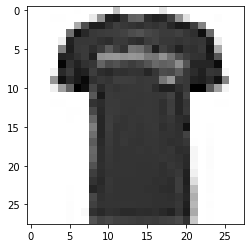

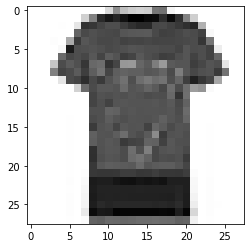

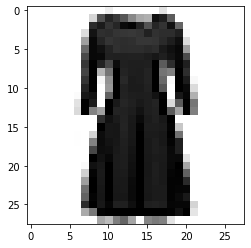

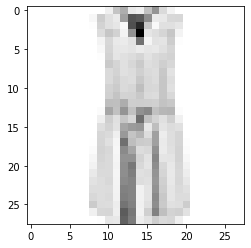

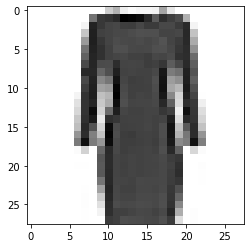

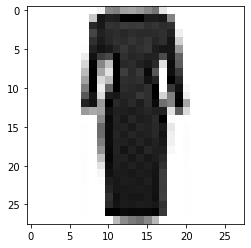

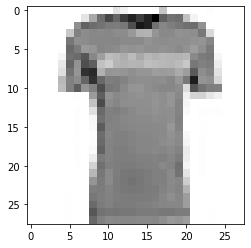

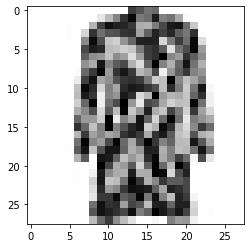

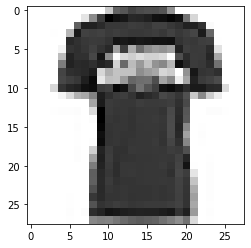

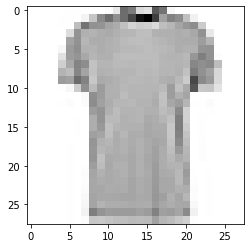

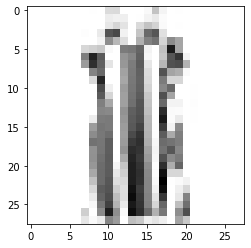

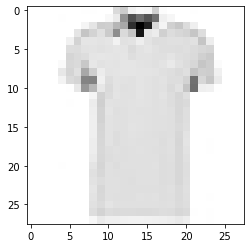

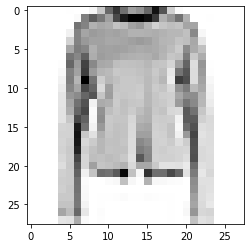

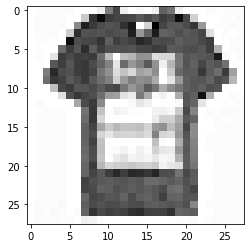

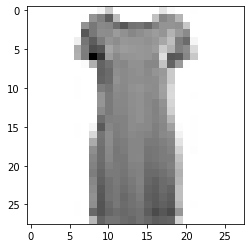

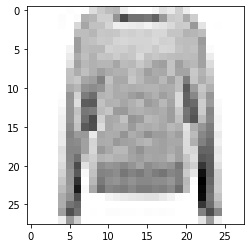

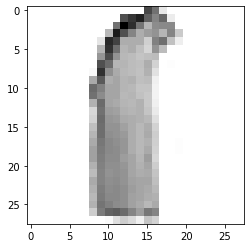

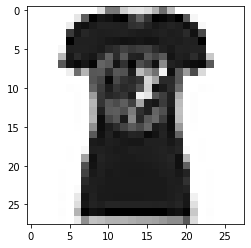

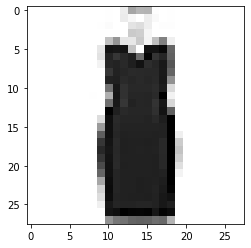

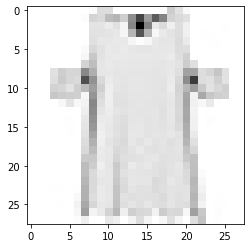

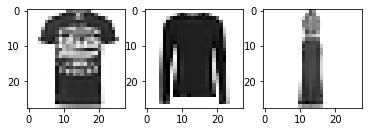

In [4]:
# Load MNIST dataset
DATA_PATH = '/content/sample_data/Fashion_MNIST.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)
print(sample_test)
for i in range(len(sample_test)):
    img = sample_test[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()
#    Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [5]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

In [6]:
LABELS = [0, 2, 3]
list_zzfeat = []
list_zfeat = []
list_pmap = []
score_zzfeat= []
score_zfeat= []
score_pmap= []
num_labels = len(LABELS)
for i in range(num_labels):

    labels_trainz = np.where(labels_train==LABELS[i], 1, 0)
    labels_valz = np.where(labels_val==LABELS[i], 1, 0)

    print(f'Original validation labels:      {labels_val}')
    print(f'Validation one label vs Rest:    {labels_valz}')
    
    # ZZfeature map to be analysed for different labels prediction with entanglement configuration : "full", "circular", "linear" 
    zzfeat_map = ZZFeatureMap(feature_dimension=N_DIM, reps=3, entanglement='linear')

    zfeat_map = ZFeatureMap(feature_dimension=N_DIM, reps=3)
    pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=3, paulis = ['X', 'Y', 'ZZ'])
    quantum_instancez = QuantumInstance(Aer.get_backend('statevector_simulator'), shots=8192, seed_simulator=1024, seed_transpiler=1024)
    kernel_zzfeat = QuantumKernel(feature_map=zzfeat_map, quantum_instance=quantum_instancez)
    kernel_zfeat = QuantumKernel(feature_map=zfeat_map, quantum_instance=quantum_instancez)
    kernel_p_map = QuantumKernel(feature_map=pauli_map, quantum_instance=quantum_instancez)
   
    svc = SVC(kernel='precomputed', probability=True)

    matrix_train_zz = kernel_zzfeat.evaluate(x_vec=sample_train)
    matrix_train_z = kernel_zfeat.evaluate(x_vec=sample_train)
    matrix_train_pmap = kernel_p_map.evaluate(x_vec=sample_train)
    svc.fit(matrix_train_zz, labels_trainz)
    svc.fit(matrix_train_z, labels_trainz)
    svc.fit(matrix_train_pmap, labels_trainz)
    

    matrix_val_zzfeat = kernel_zzfeat.evaluate(x_vec=sample_val, y_vec=sample_train)
    matrix_val_zfeat = kernel_zfeat.evaluate(x_vec=sample_val, y_vec=sample_train)
    matrix_val_pmap = kernel_p_map.evaluate(x_vec=sample_val, y_vec=sample_train)
    pauli_score_zzfeat = svc.score(matrix_val_zzfeat, labels_valz)
    pauli_score_zfeat = svc.score(matrix_val_zfeat, labels_valz)
    pauli_score_pmap = svc.score(matrix_val_pmap, labels_valz)
    print(f'Accuracy of ZZFeature Map discriminating between label and others: {pauli_score_zzfeat*100}%')
    print(f'Accuracy of ZFeature Map discriminating between label and others: {pauli_score_zfeat*100}%')
    print(f'Accuracy of Pauli Feature Map discriminating between label and others: {pauli_score_pmap*100}%')

    matrix_test_zzfeat = kernel_zzfeat.evaluate(x_vec=sample_test, y_vec=sample_train)
    matrix_test_zfeat = kernel_zfeat.evaluate(x_vec=sample_test, y_vec=sample_train)
    matrix_test_pmap = kernel_p_map.evaluate(x_vec=sample_test, y_vec=sample_train)
    #pa_zzfeat = svc.score(matrix_test_zzfeat, labels_test)
    #print(pa_zzfeat)
    pred_zzfeat = svc.predict_proba(matrix_test_zzfeat)[:, 1]
    pred_zfeat = svc.predict_proba(matrix_test_zfeat)[:, 1]
    pred_pmap = svc.predict_proba(matrix_test_pmap)[:, 1]

    print(f'Probability of label : {np.round(pred_zzfeat, 2)}')
    print(f'Probability of label : {np.round(pred_zfeat, 2)}')
    print(f'Probability of label : {np.round(pred_pmap, 2)}')

    list_zzfeat.append(np.round(pred_zzfeat, 2))
    list_zfeat.append(np.round(pred_zfeat, 2))
    list_pmap.append(np.round(pred_pmap, 2))

    score_zzfeat.append(pauli_score_zzfeat)
    score_zfeat.append(pauli_score_zfeat)
    score_pmap.append(pauli_score_pmap)
print(score_zzfeat)
print(score_zfeat)
print(score_pmap)    

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation one label vs Rest:    [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Accuracy of ZZFeature Map discriminating between label and others: 90.0%
Accuracy of ZFeature Map discriminating between label and others: 95.0%
Accuracy of Pauli Feature Map discriminating between label and others: 85.0%
Probability of label : [0.22 0.22 0.3  0.32 0.29 0.32 0.19 0.29 0.2  0.21 0.31 0.27 0.29 0.3
 0.34 0.31 0.33 0.27 0.3  0.3 ]
Probability of label : [0.11 0.1  0.36 0.27 0.38 0.45 0.13 0.28 0.1  0.16 0.28 0.22 0.42 0.31
 0.28 0.43 0.3  0.14 0.42 0.24]
Probability of label : [0.25 0.27 0.28 0.29 0.28 0.28 0.27 0.29 0.26 0.29 0.29 0.29 0.3  0.26
 0.28 0.28 0.29 0.26 0.28 0.31]
Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation one label vs Rest:    [0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0]
Accuracy of ZZFeature Map discriminating between label and others: 80.0%
Accuracy of ZFeature Map dis

In [7]:
print(score_zzfeat)
print(score_zfeat)
print(score_pmap) 

[0.9, 0.8, 0.9]
[0.95, 0.9, 0.9]
[0.85, 0.9, 0.7]


In [8]:
pred_0_zz = np.array(list_zzfeat[0])
pred_2_zz = np.array(list_zzfeat[1])
pred_3_zz = np.array(list_zzfeat[2])

In [9]:
pred_0_z = np.array(list_zfeat[0])
pred_2_z = np.array(list_zfeat[1])
pred_3_z = np.array(list_zfeat[2])

In [10]:
pred_0_pm = np.array(list_pmap[0])
pred_2_pm = np.array(list_pmap[1])
pred_3_pm = np.array(list_pmap[2])

In [11]:
pred_ZZtest = []
pred_Ztest = []
pred_Pmap  = []
pred_ZZtest.append(np.where(((pred_0_zz > pred_2_zz) & (pred_0_zz > pred_3_zz)),0,(np.where(((pred_2_zz > pred_0_zz) & (pred_2_zz > pred_3_zz)),2,3))))
pred_Ztest.append(np.where(((pred_0_z > pred_2_z) & (pred_0_z > pred_3_z)),0,(np.where(((pred_2_z > pred_0_z) & (pred_2_z > pred_3_z)),2,3))))
pred_Pmap.append(np.where(((pred_0_pm > pred_2_pm) & (pred_0_pm > pred_3_pm)),0,(np.where(((pred_2_pm > pred_0_pm) & (pred_2_pm > pred_3_pm)),2,3))))
print(f'Prediction: {pred_ZZtest}')
print(f'Prediction: {pred_Ztest}')
print(f'Prediction: {pred_Pmap}')

Prediction: [array([0, 0, 3, 3, 3, 2, 0, 2, 0, 0, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2])]
Prediction: [array([0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 2, 2, 3, 2, 3, 3, 3, 2])]
Prediction: [array([0, 2, 3, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2])]


No handles with labels found to put in legend.


[0 0 3 3 3 2 0 2 0 0 3 2 2 2 3 2 3 2 3 2]


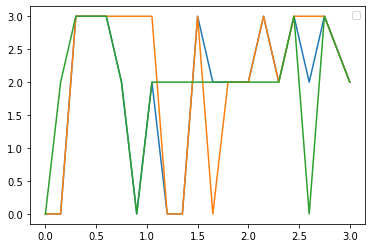

In [12]:
print(pred_ZZtest[0])
x = pred_ZZtest[0]
y = pred_Ztest[0]
z = pred_Pmap[0]
a = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5, 1.65, 1.8, 2, 2.15, 2.3, 2.45, 2.6, 2.75, 3]

# Plot a simple line chart
plt.plot(a, x)

# Plot another line on the same chart/graph
plt.plot(a, y)
plt.plot(a, z)
plt.legend()

plt.show()

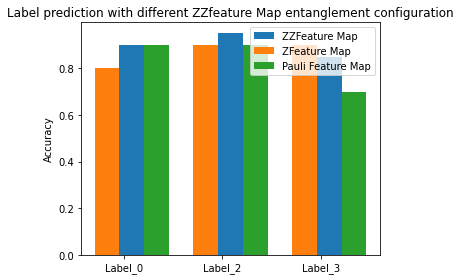

In [14]:
labels = ['Label_0', 'Label_2', 'Label_3']
Score0_plot = [score_zzfeat[0], score_zfeat[0], score_pmap[0]]
Score2_plot = [score_zzfeat[1], score_zfeat[1], score_pmap[1]]
Score3_plot = [score_zzfeat[2], score_zfeat[2], score_pmap[2]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + width/3 , Score0_plot, width, label='ZZFeature Map')
rects2 = ax.bar(x - 2*(width)/3, Score2_plot, width, label='ZFeature Map')
rects3 = ax.bar(x + 4*width/3, Score3_plot, width, label='Pauli Feature Map')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Label prediction with different ZZfeature Map entanglement configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()#loc=2, prop={'size': 6})

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)

fig.tight_layout()
#plt.figure(figsize=(500,500)) 
plt.show()

In [15]:
print(zzfeat_map)
zzfeat_map.draw()

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐└───┘»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     ├───┤├──────────────┤                                           └───┘»
q_3: ┤ H ├┤ U1(2.0*x[3]) ├────────────────────────────────────────────────»
     ├───┤├──────────────┤                                                »
q_4: ┤ H ├┤ U1(2.0*x[4]) ├────────────────────────────────────────────────»
     └───┘└──────────────┘                                                »
«              ┌──────────────┐                  »
«q_0: ─────────┤ U1(2.0*x[0]) ├──────────────────»
«              └──────────────┘             ┌───┐»
«q_1: ─────

┌─────────────────────────────────────────┐
q_0: ┤0                                        ├
     │                                         │
q_1: ┤1                                        ├
     │                                         │
q_2: ┤2 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├
     │                                         │
q_3: ┤3                                        ├
     │                                         │
q_4: ┤4                                        ├
     └─────────────────────────────────────────┘

In [16]:
print(zfeat_map)
zfeat_map.draw()

     ┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤
q_3: ┤ H ├┤ U1(2.0*x[3]) ├┤ H ├┤ U1(2.0*x[3]) ├┤ H ├┤ U1(2.0*x[3]) ├
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤
q_4: ┤ H ├┤ U1(2.0*x[4]) ├┤ H ├┤ U1(2.0*x[4]) ├┤ H ├┤ U1(2.0*x[4]) ├
     └───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘


┌────────────────────────────────────────┐
q_0: ┤0                                       ├
     │                                        │
q_1: ┤1                                       ├
     │                                        │
q_2: ┤2 ZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├
     │                                        │
q_3: ┤3                                       ├
     │                                        │
q_4: ┤4                                       ├
     └────────────────────────────────────────┘

In [17]:
print(pauli_map)
pauli_map.draw()

     ┌───┐┌───┐┌──────────────┐┌───┐┌─────────┐┌──────────────┐┌──────────┐»
q_0: ┤ H ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ Rx(π/2) ├┤ U1(2.0*x[0]) ├┤ Rx(-π/2) ├»
     ├───┤├───┤├──────────────┤├───┤├─────────┤├──────────────┤├──────────┤»
q_1: ┤ H ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ Rx(π/2) ├┤ U1(2.0*x[1]) ├┤ Rx(-π/2) ├»
     ├───┤├───┤├──────────────┤├───┤├─────────┤├──────────────┤├──────────┤»
q_2: ┤ H ├┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ Rx(π/2) ├┤ U1(2.0*x[2]) ├┤ Rx(-π/2) ├»
     ├───┤├───┤├──────────────┤├───┤├─────────┤├──────────────┤├──────────┤»
q_3: ┤ H ├┤ H ├┤ U1(2.0*x[3]) ├┤ H ├┤ Rx(π/2) ├┤ U1(2.0*x[3]) ├┤ Rx(-π/2) ├»
     ├───┤├───┤├──────────────┤├───┤├─────────┤├──────────────┤├──────────┤»
q_4: ┤ H ├┤ H ├┤ U1(2.0*x[4]) ├┤ H ├┤ Rx(π/2) ├┤ U1(2.0*x[4]) ├┤ Rx(-π/2) ├»
     └───┘└───┘└──────────────┘└───┘└─────────┘└──────────────┘└──────────┘»
«                                                     »
«q_0: ──■─────────────────────────────────────■────■──»
«     ┌─┴─┐┌─────────────────────────────

┌────────────────────────────────────────────┐
q_0: ┤0                                           ├
     │                                            │
q_1: ┤1                                           ├
     │                                            │
q_2: ┤2 PauliFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├
     │                                            │
q_3: ┤3                                           ├
     │                                            │
q_4: ┤4                                           ├
     └────────────────────────────────────────────┘